In [2]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.special import gammaincc as gamma
%matplotlib inline

/anaconda/lib/python3.6/site-packages/astropy/config/configuration.py:541: ConfigurationMissingWarning: Configuration defaults will be used due to FileExistsError:17 on None
  warn(ConfigurationMissingWarning(msg))


# Problem 1 - Galaxy Classification

If I were to devise a galaxy classification scheme, I would want it to be independent of viewing angle and less subjective than the Hubble classification. I would use the idea of classifying by color, as in the B-V vs Hubble classification figure in Robert and Haynes (1994).  The color seems to be a very good proxy for the visual classification of galaxies, but with the advantage of being less subjective (a galaxy can have a single numerical value), independent of observing angle, and has definied wavelengths at which it is defined. If I were to make the classification a bit more complicated, I would have each galaxy described by two numbers: color and luminosity (maybe at one of the bands used in the color measurment, e.g., B-V color and V band luminosity). This would encode additional information about the size/age of the galaxy.

# Problem 2 - Galaxy Correlations in SDSS


### 2a
The dependence of metallicity on solar mass may be in part explained by outflows.  Galaxies of smaller mass have lower metal abundances because their lower escape velocities.

### 2c
At given stellar mass, the strength of the correlation between gas-phase metallicity and star formation rate varies, as shown in the figure below.  Correlation coefficient between Z and SFR is plotted as a function of stellar mass, with red regions showing weak correlation and yellow showing moderate correlation (assuming a linear relationship).  The correlation is strongest (and positive) at the lowest and highest ends of the mass range.

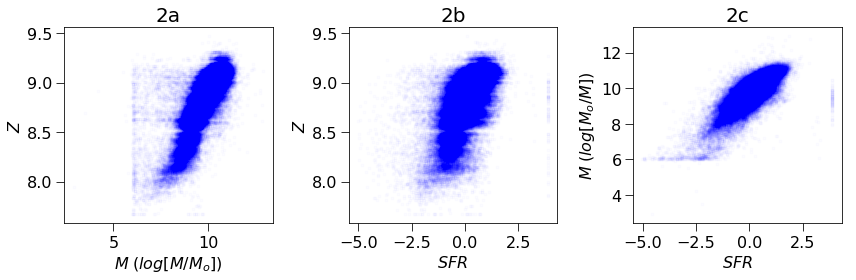

In [28]:
Z_tab = Table.read("gal_fiboh_dr7_v5_2.fits"); M_tab = Table.read("totlgm_dr7_v5_2.fit"); S_tab = Table.read("gal_totsfr_dr7_v5_2.fits")
idx = np.where((M_tab['MEDIAN']>0) & (Z_tab['MEDIAN']>0) & (S_tab['MEDIAN']>-50))
M = M_tab['MEDIAN'][idx]; Z = Z_tab['MEDIAN'][idx]; S = S_tab['MEDIAN'][idx]
M, Z, S = (np.array(t) for t in zip(*sorted(zip(M, Z, S))))

plt.figure(1, figsize=(12,4))
plt.subplot(131); plt.title('2a'); plt.plot(M, Z, 'b.', alpha=0.01)
plt.xlabel('$M\;(log[M/M_{o}])$', fontsize=16); plt.ylabel('$Z$', fontsize=16)
plt.subplot(132); plt.title('2b'); plt.plot(S, Z, 'b.', alpha=0.01)
plt.xlabel('$SFR$', fontsize=16); plt.ylabel('$Z$', fontsize=16);
plt.subplot(133); plt.title('2c'); plt.plot(S, M, 'b.', alpha=0.01)
plt.xlabel('$SFR$', fontsize=16); plt.ylabel('$M\;(log[M_{o}/M])$', fontsize=16)
plt.tight_layout()

### 2d
A positive correlation between Z and SFR makes sense, considering that a galaxy with a high SFR is producing stars, and therefore processing gas and increasing Z, regardless of how much mass there is to begin with. If I had to come up with an explanation for the negative correlation (which isn't very strong in the data, but just for fun), I would guess that a galaxy undergoing a lot of star formation is still young (assuming a low SFR means that formation has slowed down and previously was high) and therefore hasn't had as much of a chance to produce heavier elements in its' stars. I can't, however, explain why these correlations would differe at different stellas masses.

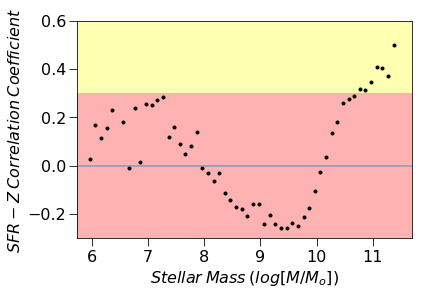

In [25]:
M_bins = np.arange(M[12], M[-1], .1)
corrs = np.zeros(len(M_bins))
for i in range(len(M_bins)-1):
    idx = np.where((M > M_bins[i]) & (M < M_bins[i+1]))
    if len(M[idx]) > 50:
        corrs[i] = np.corrcoef(Z[idx], S[idx])[0,1]
good = np.where(corrs != 0)    
plt.plot(M_bins[good], corrs[good], 'k.')
plt.axhspan(-0.3, 0.3, color='red', alpha=0.3)
plt.axhspan(0.3, 0.7, color='yellow', alpha=0.3)
plt.axhline(0, alpha=0.5)
plt.axis([5.75, 11.7, -.3, 0.6])
plt.xlabel('$Stellar \: Mass \:(log[M/M_o])$', fontsize=16)
plt.ylabel('$SFR-Z \:Correlation \: Coefficient$', fontsize=16);

# Problem 3 - Magnitudes, Fluxes, and K-Corrections

In [19]:
m_g = 16.86
z = 0.1
c = 3e5 # km/s
H = 70.4  #km /s /Mpc
v =  c * z #km /s 
d = (v / H) * 1e6 #pc
M_g = m_g - 5 * np.log10(d/10)
print("Absolute magnitude in g-band:", M_g)

Absolute magnitude in g-band: -21.2877429779


# 3b-c

3c. Though close, the observed spectrum does not overlap with the SED. This might have something to do with the observation methods of both data sets; I would assume that the individual magnitudes' photometry come from a different instrument than the spectrum, and the difference in instruments could potentially be enough to explain the factor of ~2 or 3 difference.

3d. I used the g-band response function for an exteded source (because this galaxy is resolved by SDSS and is not a point source) at an airmass of 1.3 (because SDSS data was taken with a ground-based telescsope).

e. [10 points] As is clear from the figure made in the d, the observed and rest-frame magnitudes will be different.
Use the spectrum to calculate the K-correction in the g-band. Please note that the response functions are
determined for photon-counting detectors, which means you have to integrate in λ Fλ or ν Fν.

f. [6 points] What is rest-frame g-band luminosity of this galaxy?

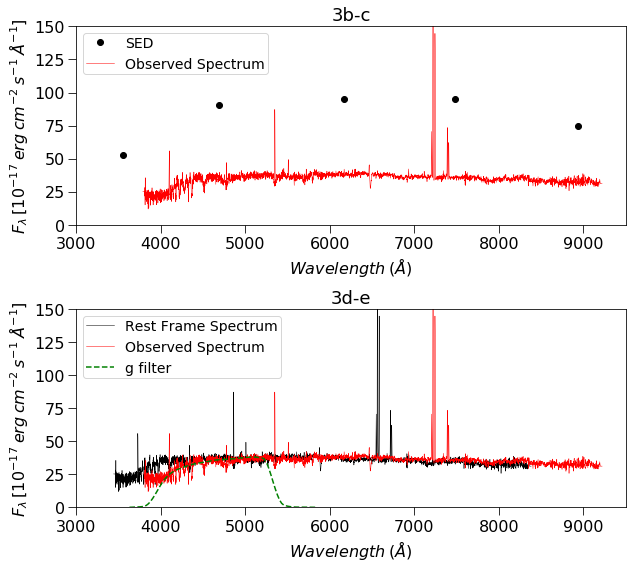

In [30]:
# organize photometry data
filters = ['u', 'g', 'r', 'i', 'z']
mags = np.array([18.06, 16.88, 16.23, 15.81, 15.69])
mag_errs = np.array([0.02, 0, 0, 0, 0.01])
cents = np.array([3551, 4686, 6165, 7481, 8931])

# calculate flux magnitudes
ν = 3e18 / cents
f_ν = 10**((mags+48.57)/(-2.5))
f_λ = f_ν * ν**2 / (3e8 * 1e10)
f_ν_err = 10**((mag_errs+48.57)/(-2.5))
f_λ_err = f_ν_err * ν**2 / (3e8 * 1e10)

#Read in spec file
spec_file = "spSpec-51788-0401-161.fit"
hdul = fits.open(spec_file)
hdr = hdul[0].header
data = hdul[0].data
spec = np.array(data[0])
spec_err = np.array(data[2])
x = np.arange(0, hdr['NAXIS1'], 1)
λ = 10**(hdr['COEFF0'] + hdr['COEFF1'] * x)

#Calculate rest frame spectrum from redshift
z = hdr['Z']
λ_rf = λ / (z+1)

g_band = Table.read('g.dat', format='ascii')

#Plot stuff
plt.figure(1, figsize=(9, 8))
plt.subplot(211)
plt.plot(cents, f_λ*1e17, 'ko', label='SED')
plt.plot(λ, spec, 'r-', linewidth=0.5, label='Observed Spectrum')
plt.axis([3000, 9500, 0, 150])
plt.xlabel('$Wavelength \: (\AA)$', fontsize=16)
plt.ylabel('$F_\lambda \: [10^{-17} \: erg \: cm^{-2} \: s^{-1} \: \AA^{-1}]$', fontsize=16)
plt.title('3b-c', fontsize=18)
plt.legend(loc=2, fontsize=14)

plt.subplot(212)
plt.title('3d-e', fontsize=18)
plt.plot(λ_rf, spec, 'k-', linewidth=0.5, label='Rest Frame Spectrum')
plt.plot(λ, spec, 'r-', linewidth=0.5, label='Observed Spectrum')
plt.plot(g_band['col1'], g_band['col4']*38/.42, 'g--', label='g filter')
plt.axis([3000, 9500, 0, 150])
plt.xlabel('$Wavelength \: (\AA)$', fontsize=16)
plt.ylabel('$F_\lambda \: [10^{-17} \: erg \: cm^{-2} \: s^{-1} \: \AA^{-1}]$', fontsize=16)
plt.legend(loc=2, fontsize=14)

plt.tight_layout()

In [73]:
f_λ = 0
f_λ_rf = 0

for i in range(len(λ)-1):
    T = g_band['col4'][np.argmin(abs(λ[i]-g_band['col1']))]
    T_rf = g_band['col4'][np.argmin(abs(λ_rf[i]-g_band['col1']))]
    f_λ += spec[i] * (λ[i+1]-λ[i]) * T
    f_λ_rf += spec[i] * (λ_rf[i+1]-λ_rf[i]) * T_rf

print('Observed f_λ in g-band: ', np.round(f_λ, 0), 'Rest frame f_λ in g-band: ', np.round(f_λ_rf, 0), '(1e-17 erc/cm^2/s)')

k = -2.5 * np.log10((1/(1+z))*(f_λ/f_λ_rf))
print("k-correction: " , np.round(k, 3))

Observed f_λ in g-band:  17292.0 Rest frame f_λ in g-band:  18572.0 (1e-17 erc/cm^2/s)
k-correction:  0.181


# Problem 4 - Schecter Function

### 4a - Derivation on attached sheet.

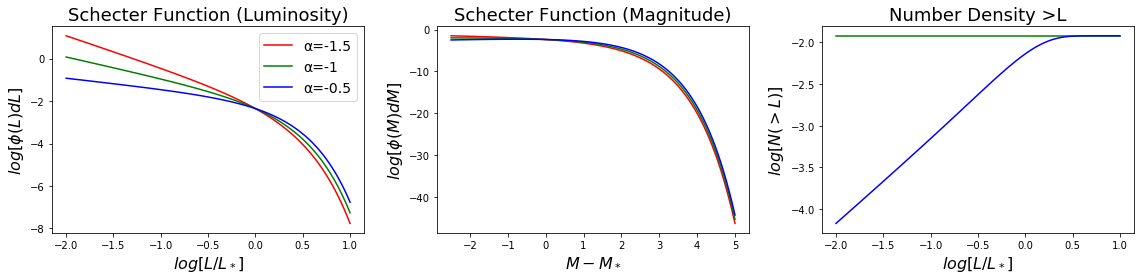

In [70]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


α = [-1.5, -1, -0.5]
colors = ['r', 'g', 'b']
L_L = np.logspace(-2, 1, 100) # x=L/L*
ϕ_s = 1.2e-2
M_M = -2.5 * np.log10(x)

plt.figure(figsize=(16,4))
for i in range(3):

    # Luminoisty function
    ϕL = ϕ_s * x**α[i] * np.exp(-L_L)

    # In Magnitude
    nM = 0.4 * np.log(10)*ϕ_s*(10**(0.4*M_M*(α[i]+1)))*np.exp(-10**(0.4*M_M))

    # Numbr density
    nL = ϕ_s * gamma(L_L, α[i]+1)

    plt.subplot(131)
    plt.plot(np.log10(L_L), np.log10(ϕL), '-', color=colors[i], label='α='+str(α[i]))
    plt.xlabel('$log[L/L_*]$', fontsize=16)
    plt.ylabel('$log[\phi(L)dL]$', fontsize=16)
    plt.title('Schecter Function (Luminosity)', fontsize=18)

    plt.subplot(132)
    plt.plot(M_M, np.log10(nM), '-', color=colors[i])
    #plt.gca().invert_xaxis()
    plt.xlabel('$M-M_*$', fontsize=16)
    plt.ylabel('$log[\phi(M)dM]$', fontsize=16)
    plt.title('Schecter Function (Magnitude)', fontsize=18)
    #plt.axis([-3, 3, -15, 0])

    plt.subplot(133)
    plt.plot(np.log10(L_L), np.log10(nL), '-', color=colors[i])
    plt.xlabel('$log[L/L_*]$', fontsize=16)
    plt.ylabel('$log[N(>L)]$', fontsize=16)
    plt.title('Number Density >L', fontsize=18)

plt.subplot(131)
plt.legend(fontsize=14)
plt.tight_layout()

#### 4c: 
The shape of the luminosity and mass functions differ because there is not a one to one mapping of luminosity and stellar mass; a galaxy's stellar mass is essentially set at the begining with little change over time, while the same galaxy's luminosity will change as the stars within it evolve. As such, the shape of the luminosity function will be more sensitive to galaxy ages, while a mass function would not be as dependent.

#### 4d:
In order to derive a non-trivial mass function from the luminosity function, we would need a mass-luminosity relation, which is not standard between colors.  As such, there isn't enough information to make this plot in a way that would look differently than the luminosity function above (we would have to assume some color-constant M-L relation, which would just change the normalization of the plot.